# Creating a classifier to idenify images containing rust.

The classifier will be trained on a small set of images taken from a small subsample of HCC bridge inspection photographs.

As the set of training images is small transfer learning will be used using the Xception neural net in Keras pretrained on the Imagenet dataset.

To supplement the training data image preprocessing will be used generate additional transformed images for training.

In [1]:
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from keras import applications
from keras import optimizers
from keras.models import Sequential, Model 
from keras.layers import Dropout, Flatten, Dense, GlobalAveragePooling2D
from keras import backend as k 
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, TensorBoard, EarlyStopping

img_width, img_height = 224, 224
train_data_dir = "data/train"
validation_data_dir = "data/validation"
nb_train_samples = 777 + 761
nb_validation_samples = 194 + 190
batch_size = 8
epochs = 50

datagen = ImageDataGenerator(
        rotation_range=30,
        width_shift_range=0.1,
        height_shift_range=0.1,
        rescale=1./255,
        shear_range=0.1,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest')

C:\Users\lnath0\AppData\Local\Continuum\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [3]:
# Test the datagenerator on a sample image from the rust training images

# img = load_img('data/train/rust/5_0052 (31) (Small).jpg')  # this is a PIL image
# x = img_to_array(img)  # this is a Numpy array with shape (3, 150, 150)
# x = x.reshape((1,) + x.shape)  # this is a Numpy array with shape (1, 3, 150, 150)

# the .flow() command below generates batches of randomly transformed images
# and saves the results to the `preview/` directory
i = 0
for batch in datagen.flow_from_directory("data/train", batch_size=1, target_size=(img_width, img_height),
                                         save_to_dir='preview', save_prefix='no_rust', save_format='jpeg'):
    i += 1
    if i > 2000:
        break  # otherwise the generator would loop indefinitely

Found 777 images belonging to 1 classes.


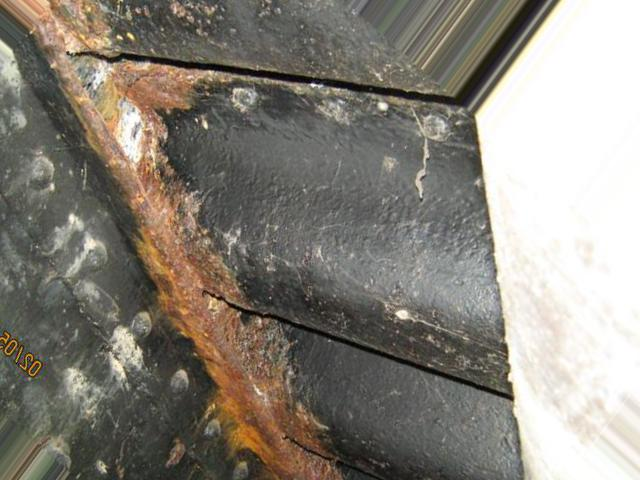

In [3]:
# Preview one of the augmented data produced

# from IPython.display import Image
# Image('preview/rust_0_1980.jpeg')


In [2]:
# Bring in the Xception model to use as the base net for transfer learning
# The Xception model is selected as it is high accuracy for its small size.

model = applications.Xception(weights = "imagenet", include_top=False, input_shape = (img_width, img_height, 3))

# model = applications.MobileNet(weights = "imagenet", include_top=False, input_shape = (img_width, img_height, 3))

In [3]:
# View the model summary to see the layers of the network

model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 111, 111, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, 111, 111, 32) 128         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_conv1_act (Activation)   (None, 111, 111, 32) 0           block1_conv1_bn[0][0]            
__________________________________________________________________________________________________
block1_con

In [4]:
# Check the layer names to decide which layers to train and freeze for later in the process

for i, layer in enumerate(model.layers):
    print('layer:', i, ' Name:', layer.name)

layer: 0  Name: input_1
layer: 1  Name: block1_conv1
layer: 2  Name: block1_conv1_bn
layer: 3  Name: block1_conv1_act
layer: 4  Name: block1_conv2
layer: 5  Name: block1_conv2_bn
layer: 6  Name: block1_conv2_act
layer: 7  Name: block2_sepconv1
layer: 8  Name: block2_sepconv1_bn
layer: 9  Name: block2_sepconv2_act
layer: 10  Name: block2_sepconv2
layer: 11  Name: block2_sepconv2_bn
layer: 12  Name: conv2d_1
layer: 13  Name: block2_pool
layer: 14  Name: batch_normalization_1
layer: 15  Name: add_1
layer: 16  Name: block3_sepconv1_act
layer: 17  Name: block3_sepconv1
layer: 18  Name: block3_sepconv1_bn
layer: 19  Name: block3_sepconv2_act
layer: 20  Name: block3_sepconv2
layer: 21  Name: block3_sepconv2_bn
layer: 22  Name: conv2d_2
layer: 23  Name: block3_pool
layer: 24  Name: batch_normalization_2
layer: 25  Name: add_2
layer: 26  Name: block4_sepconv1_act
layer: 27  Name: block4_sepconv1
layer: 28  Name: block4_sepconv1_bn
layer: 29  Name: block4_sepconv2_act
layer: 30  Name: block4_sep

In [5]:
# There are 2778 no-rust photos
# There are 2762 rust photos

generator = datagen.flow_from_directory(
        'data/train',
        target_size=(img_width, img_height),
        batch_size=batch_size,
        class_mode=None,  # this means our generator will only yield batches of data, no labels
        shuffle=False)  # our data will be in order, so all first 2778 images will be no rust, then 2762 rust

Found 1538 images belonging to 2 classes.


In [6]:
import numpy as np

# the predict_generator method returns the output of a model, given
# a generator that yields batches of numpy data
bottleneck_features_train = model.predict_generator(generator, 5540)
# save the output as a Numpy array
np.save(open('bottleneck_features_train.npy', 'wb'), bottleneck_features_train)

KeyboardInterrupt: 

In [ ]:
# Run the python file created to get bottleneck features

# %run main_run.py

C:\Users\Marsilea\Anaconda3\lib\site-packages\h5py\__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


Found 5540 images belonging to 2 classes.


In [21]:
# Firstly we will freeze all the layers in the network as not trainable and train a classifier on top of the network
for layer in model.layers[:117]:
    layer.trainable = False
    
for layer in model.layers[117:]:
    layer.trainable = True

In [3]:
#Adding custom Layers 

x = model.output
x = Flatten()(x)
x = Dense(256, activation="relu")(x)
x = Dropout(0.5)(x)
x = Dense(512, activation="relu")(x)
predictions = Dense(1, activation="sigmoid")(x)

model_final = Model(model.input, predictions)

In [23]:
# Check the new combined network with the Xception network and classifier network on top

model_final.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 111, 111, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, 111, 111, 32) 128         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_conv1_act (Activation)   (None, 111, 111, 32) 0           block1_conv1_bn[0][0]            
__________________________________________________________________________________________________
block1_con

In [24]:
# Check only the classifier layers are trainable initially
for layer in model_final.layers:
    if layer.trainable:
        print(layer)

In [25]:
# compile the model 
model_final.compile(optimizer=optimizers.SGD(lr=1e-4, momentum=0.9),
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [26]:
# Initiate the train and test generators with data Augumentation 
train_datagen = ImageDataGenerator(
rescale = 1./255,
horizontal_flip = True,
fill_mode = "nearest",
zoom_range = 0.3,
width_shift_range = 0.3,
height_shift_range=0.3,
rotation_range=30)

test_datagen = ImageDataGenerator(
rescale = 1./255,
horizontal_flip = True,
fill_mode = "nearest",
zoom_range = 0.3,
width_shift_range = 0.3,
height_shift_range=0.3,
rotation_range=30)

In [27]:

train_generator = train_datagen.flow_from_directory(
train_data_dir,
target_size = (img_height, img_width),
batch_size = batch_size, 
class_mode = "binary")

validation_generator = test_datagen.flow_from_directory(
validation_data_dir,
target_size = (img_height, img_width),
class_mode = "binary")

Found 1538 images belonging to 2 classes.
Found 384 images belonging to 2 classes.


In [28]:
# Save the model according to the conditions  
checkpoint = ModelCheckpoint("xception_1.h5", monitor='val_acc', verbose=1, save_best_only=True, save_weights_only=False, mode='auto', period=1)
early = EarlyStopping(monitor='val_acc', min_delta=0, patience=10, verbose=1, mode='auto')

In [29]:
# Train the model 
model_final.fit_generator(
train_generator,
steps_per_epoch = nb_train_samples / batch_size,
epochs = epochs,
validation_data = validation_generator,
validation_steps = nb_validation_samples / batch_size,
callbacks = [checkpoint, early])

Epoch 1/50
193/192 [==============================] - 66s 344ms/step - loss: 0.6731 - acc: 0.5842 - val_loss: 0.5965 - val_acc: 0.6914

Epoch 00001: val_acc improved from -inf to 0.69141, saving model to xception_1.h5
Epoch 2/50
193/192 [==============================] - 64s 332ms/step - loss: 0.6011 - acc: 0.7001 - val_loss: 0.5788 - val_acc: 0.6764

Epoch 00002: val_acc did not improve from 0.69141
Epoch 3/50
193/192 [==============================] - 64s 332ms/step - loss: 0.5551 - acc: 0.7247 - val_loss: 0.5867 - val_acc: 0.6823

Epoch 00003: val_acc did not improve from 0.69141
Epoch 4/50
193/192 [==============================] - 64s 331ms/step - loss: 0.5397 - acc: 0.7260 - val_loss: 0.4940 - val_acc: 0.7624

Epoch 00004: val_acc improved from 0.69141 to 0.76237, saving model to xception_1.h5
Epoch 5/50
193/192 [==============================] - 64s 333ms/step - loss: 0.5109 - acc: 0.7552 - val_loss: 0.6339 - val_acc: 0.6803

Epoch 00005: val_acc did not improve from 0.76237
Epo

### To do

Now that the top most layers have been trained to a good accuracy. Set some of the mid and lower layers to trainable, set a low learning rate and continue training with fine tuning the mid and lower layers.

In [4]:
# Load the pretrained model
model_final.load_weights("xception_1.h5")


In [5]:
# Check only the classifier layers are trainable initially
for layer in model_final.layers:
    if layer.trainable:
        print(layer)


In [6]:
# Set more layers to trainable
for layer in model.layers[:77]:
    layer.trainable = False
    
for layer in model.layers[77:]:
    layer.trainable = True


In [7]:
# compile the model 
model_final.compile(optimizer=optimizers.SGD(lr=1e-5, momentum=0.9),
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Initiate the train and test generators with data Augumentation 
train_datagen = ImageDataGenerator(
rescale = 1./255,
horizontal_flip = True,
fill_mode = "nearest",
zoom_range = 0.3,
width_shift_range = 0.3,
height_shift_range=0.3,
rotation_range=30)

test_datagen = ImageDataGenerator(
rescale = 1./255,
horizontal_flip = True,
fill_mode = "nearest",
zoom_range = 0.3,
width_shift_range = 0.3,
height_shift_range=0.3,
rotation_range=30)


train_generator = train_datagen.flow_from_directory(
train_data_dir,
target_size = (img_height, img_width),
batch_size = batch_size, 
class_mode = "binary")

validation_generator = test_datagen.flow_from_directory(
validation_data_dir,
target_size = (img_height, img_width),
class_mode = "binary")

# Save the model according to the conditions  
checkpoint = ModelCheckpoint("xception_2.h5", monitor='val_acc', verbose=1, save_best_only=True, save_weights_only=False, mode='auto', period=1)
early = EarlyStopping(monitor='val_acc', min_delta=0, patience=15, verbose=1, mode='auto')

Found 1538 images belonging to 2 classes.
Found 384 images belonging to 2 classes.


In [ ]:
# Train the model 
model_final.fit_generator(
train_generator,
steps_per_epoch = nb_train_samples / batch_size,
epochs = epochs,
validation_data = validation_generator,
validation_steps = nb_validation_samples / batch_size,
callbacks = [checkpoint, early])

Epoch 1/50
193/192 [==============================] - 76s 394ms/step - loss: 0.3172 - acc: 0.8607 - val_loss: 0.4808 - val_acc: 0.7930

Epoch 00001: val_acc improved from -inf to 0.79297, saving model to xception_2.h5
Epoch 2/50
193/192 [==============================] - 69s 355ms/step - loss: 0.3441 - acc: 0.8472 - val_loss: 0.4962 - val_acc: 0.7858

Epoch 00002: val_acc did not improve from 0.79297
Epoch 3/50
193/192 [==============================] - 69s 356ms/step - loss: 0.3422 - acc: 0.8575 - val_loss: 0.4700 - val_acc: 0.8145

Epoch 00003: val_acc improved from 0.79297 to 0.81445, saving model to xception_2.h5
Epoch 4/50
193/192 [==============================] - 69s 356ms/step - loss: 0.3301 - acc: 0.8620 - val_loss: 0.4645 - val_acc: 0.8145

Epoch 00004: val_acc did not improve from 0.81445
Epoch 5/50
193/192 [==============================] - 69s 356ms/step - loss: 0.3325 - acc: 0.8523 - val_loss: 0.4725 - val_acc: 0.8079

Epoch 00005: val_acc did not improve from 0.81445
Epo

## Try a mobilenet

In [2]:
# Bring in the Xception model to use as the base net for transfer learning
# The Xception model is selected as it is high accuracy for its small size.

# model = applications.Xception(weights = "imagenet", include_top=False, input_shape = (img_width, img_height, 3))

model = applications.MobileNet(weights = "imagenet", include_top=False, input_shape = (img_width, img_height, 3))

17227776/17225924 [==============================] - 2s 0us/step


In [3]:
#Adding custom Layers 

x = model.output
x = Flatten()(x)
x = Dense(16, activation="relu")(x)
x = Dropout(0.5)(x)
x = Dense(16, activation="relu")(x)
predictions = Dense(1, activation="sigmoid")(x)

model_final = Model(model.input, predictions)

In [4]:
# compile the model 
model_final.compile(optimizer=optimizers.Adam(),
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [5]:
# Check only the classifier layers are trainable initially
for layer in model_final.layers:
    if layer.trainable:
        print(layer)


In [6]:
# compile the model 
model_final.compile(optimizer=optimizers.SGD(lr=1e-5, momentum=0.9),
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Initiate the train and test generators with data Augumentation 
train_datagen = ImageDataGenerator(
rescale = 1./255,
horizontal_flip = True,
fill_mode = "nearest",
zoom_range = 0.3,
width_shift_range = 0.3,
height_shift_range=0.3,
rotation_range=30)

test_datagen = ImageDataGenerator(
rescale = 1./255,
horizontal_flip = True,
fill_mode = "nearest",
zoom_range = 0.3,
width_shift_range = 0.3,
height_shift_range=0.3,
rotation_range=30)


train_generator = train_datagen.flow_from_directory(
train_data_dir,
target_size = (img_height, img_width),
batch_size = batch_size, 
class_mode = "binary")

validation_generator = test_datagen.flow_from_directory(
validation_data_dir,
target_size = (img_height, img_width),
class_mode = "binary")

# Save the model according to the conditions  
checkpoint = ModelCheckpoint("mobilenet_1.h5", monitor='val_acc', verbose=1, save_best_only=True, save_weights_only=False, mode='auto', period=1)
early = EarlyStopping(monitor='val_acc', min_delta=0, patience=15, verbose=1, mode='auto')

Found 1538 images belonging to 2 classes.
Found 384 images belonging to 2 classes.


In [7]:
# Train the model 
model_final.fit_generator(
train_generator,
steps_per_epoch = nb_train_samples / batch_size,
epochs = epochs,
validation_data = validation_generator,
validation_steps = nb_validation_samples / batch_size,
callbacks = [checkpoint, early])

Epoch 1/50
193/192 [==============================] - 76s 394ms/step - loss: 0.8078 - acc: 0.5194 - val_loss: 0.6828 - val_acc: 0.5553

Epoch 00001: val_acc improved from -inf to 0.55534, saving model to mobilenet_1.h5
Epoch 2/50
193/192 [==============================] - 65s 339ms/step - loss: 0.6958 - acc: 0.5350 - val_loss: 0.6744 - val_acc: 0.5677

Epoch 00002: val_acc improved from 0.55534 to 0.56771, saving model to mobilenet_1.h5
Epoch 3/50
193/192 [==============================] - 67s 348ms/step - loss: 0.6963 - acc: 0.5246 - val_loss: 0.6752 - val_acc: 0.5638

Epoch 00003: val_acc did not improve from 0.56771
Epoch 4/50
193/192 [==============================] - 65s 339ms/step - loss: 0.6976 - acc: 0.5207 - val_loss: 0.6775 - val_acc: 0.5768

Epoch 00004: val_acc improved from 0.56771 to 0.57682, saving model to mobilenet_1.h5
Epoch 5/50
193/192 [==============================] - 65s 337ms/step - loss: 0.6858 - acc: 0.5272 - val_loss: 0.6736 - val_acc: 0.5716

Epoch 00005: va

Epoch 41/50
193/192 [==============================] - 66s 343ms/step - loss: 0.4978 - acc: 0.7429 - val_loss: 0.4254 - val_acc: 0.8294

Epoch 00041: val_acc did not improve from 0.83203
Epoch 42/50
193/192 [==============================] - 67s 349ms/step - loss: 0.5121 - acc: 0.7545 - val_loss: 0.4259 - val_acc: 0.8197

Epoch 00042: val_acc did not improve from 0.83203
Epoch 43/50
193/192 [==============================] - 66s 339ms/step - loss: 0.5002 - acc: 0.7675 - val_loss: 0.4176 - val_acc: 0.8171

Epoch 00043: val_acc did not improve from 0.83203
Epoch 44/50
193/192 [==============================] - 66s 342ms/step - loss: 0.4860 - acc: 0.7552 - val_loss: 0.4056 - val_acc: 0.8333

Epoch 00044: val_acc improved from 0.83203 to 0.83333, saving model to mobilenet_1.h5
Epoch 45/50
193/192 [==============================] - 66s 342ms/step - loss: 0.4854 - acc: 0.7668 - val_loss: 0.3991 - val_acc: 0.8424

Epoch 00045: val_acc improved from 0.83333 to 0.84245, saving model to mobilene

### Try the Xception model again using Adam optimiser as a change

In [13]:
# Bring in the Xception model to use as the base net for transfer learning
# The Xception model is selected as it is high accuracy for its small size.

model = applications.Xception(weights = "imagenet", include_top=False, input_shape = (img_width, img_height, 3))

# model = applications.MobileNet(weights = "imagenet", include_top=False, input_shape = (img_width, img_height, 3))

In [14]:
#Adding custom Layers 

x = model.output
x = Flatten()(x)
x = Dense(16, activation="relu")(x)
x = Dropout(0.5)(x)
x = Dense(16, activation="relu")(x)
predictions = Dense(1, activation="sigmoid")(x)

model_final = Model(model.input, predictions)

In [21]:
# Set more layers to trainable
for layer in model_final.layers[:132]:
    layer.trainable = False
    
for layer in model_final.layers[132:]:
    layer.trainable = True

In [22]:
# Check only the classifier layers are trainable initially
for layer in model_final.layers:
    if layer.trainable ==True:
        print(layer)


In [23]:
# compile the model 
model_final.compile(optimizer=optimizers.Adam(),
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Initiate the train and test generators with data Augumentation 
train_datagen = ImageDataGenerator(
rescale = 1./255,
horizontal_flip = True,
fill_mode = "nearest",
zoom_range = 0.3,
width_shift_range = 0.3,
height_shift_range=0.3,
rotation_range=30)

test_datagen = ImageDataGenerator(
rescale = 1./255,
horizontal_flip = True,
fill_mode = "nearest",
zoom_range = 0.3,
width_shift_range = 0.3,
height_shift_range=0.3,
rotation_range=30)


train_generator = train_datagen.flow_from_directory(
train_data_dir,
target_size = (img_height, img_width),
batch_size = batch_size, 
class_mode = "binary")

validation_generator = test_datagen.flow_from_directory(
validation_data_dir,
target_size = (img_height, img_width),
class_mode = "binary")

# Save the model according to the conditions  
checkpoint = ModelCheckpoint("xception_3.h5", monitor='val_acc', verbose=1, save_best_only=True, save_weights_only=False, mode='auto', period=1)
early = EarlyStopping(monitor='val_acc', min_delta=0, patience=15, verbose=1, mode='auto')

Found 1538 images belonging to 2 classes.
Found 384 images belonging to 2 classes.


In [24]:
# Train the model 
model_final.fit_generator(
train_generator,
steps_per_epoch = nb_train_samples / batch_size,
epochs = epochs,
validation_data = validation_generator,
validation_steps = nb_validation_samples / batch_size,
callbacks = [checkpoint, early])

Epoch 1/50
193/192 [==============================] - 67s 345ms/step - loss: 0.7428 - acc: 0.5006 - val_loss: 0.6820 - val_acc: 0.6986

Epoch 00001: val_acc improved from -inf to 0.69857, saving model to xception_3.h5
Epoch 2/50
193/192 [==============================] - 64s 330ms/step - loss: 0.6813 - acc: 0.5810 - val_loss: 0.6134 - val_acc: 0.7474

Epoch 00002: val_acc improved from 0.69857 to 0.74740, saving model to xception_3.h5
Epoch 3/50
193/192 [==============================] - 64s 329ms/step - loss: 0.6503 - acc: 0.5991 - val_loss: 0.5838 - val_acc: 0.7702

Epoch 00003: val_acc improved from 0.74740 to 0.77018, saving model to xception_3.h5
Epoch 4/50
193/192 [==============================] - 64s 330ms/step - loss: 0.6488 - acc: 0.6218 - val_loss: 0.5526 - val_acc: 0.7630

Epoch 00004: val_acc did not improve from 0.77018
Epoch 5/50
193/192 [==============================] - 64s 330ms/step - loss: 0.6471 - acc: 0.6146 - val_loss: 0.6020 - val_acc: 0.7220

Epoch 00005: val_a

KeyboardInterrupt: 

In [25]:
# Set more layers to trainable
for layer in model_final.layers[:77]:
    layer.trainable = False
    
for layer in model_final.layers[77:]:
    layer.trainable = True

In [26]:
# Train the model 
model_final.fit_generator(
train_generator,
steps_per_epoch = nb_train_samples / batch_size,
epochs = epochs,
validation_data = validation_generator,
validation_steps = nb_validation_samples / batch_size,
callbacks = [checkpoint, early])

/usr/local/lib/python3.5/dist-packages/keras/engine/training.py:478: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


Epoch 1/50
193/192 [==============================] - 66s 341ms/step - loss: 0.6266 - acc: 0.6490 - val_loss: 0.5721 - val_acc: 0.7539

Epoch 00001: val_acc did not improve from 0.77018
Epoch 2/50
193/192 [==============================] - 64s 329ms/step - loss: 0.6274 - acc: 0.6373 - val_loss: 0.5727 - val_acc: 0.7467

Epoch 00002: val_acc did not improve from 0.77018
Epoch 3/50
193/192 [==============================] - 64s 330ms/step - loss: 0.6427 - acc: 0.6237 - val_loss: 0.6092 - val_acc: 0.6921

Epoch 00003: val_acc did not improve from 0.77018
Epoch 4/50
193/192 [==============================] - 64s 330ms/step - loss: 0.6102 - acc: 0.6496 - val_loss: 0.6030 - val_acc: 0.6823

Epoch 00004: val_acc did not improve from 0.77018
Epoch 5/50
193/192 [==============================] - 64s 331ms/step - loss: 0.6175 - acc: 0.6412 - val_loss: 0.5378 - val_acc: 0.7852

Epoch 00005: val_acc improved from 0.77018 to 0.78516, saving model to xception_3.h5
Epoch 6/50
193/192 [===============

KeyboardInterrupt: 

In [29]:
# Set more layers to trainable
    
for layer in model_final.layers[:]:
    layer.trainable = True

In [30]:
# compile the model 
model_final.compile(optimizer=optimizers.Adam(),
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [ ]:
# Train the model 
model_final.fit_generator(
train_generator,
steps_per_epoch = nb_train_samples / batch_size,
epochs = epochs,
validation_data = validation_generator,
validation_steps = nb_validation_samples / batch_size,
callbacks = [checkpoint, early])

Epoch 1/50
193/192 [==============================] - 126s 651ms/step - loss: 0.7146 - acc: 0.5557 - val_loss: 0.9671 - val_acc: 0.6654

Epoch 00001: val_acc did not improve from 0.81445
Epoch 2/50
193/192 [==============================] - 114s 590ms/step - loss: 0.6959 - acc: 0.5201 - val_loss: 0.7055 - val_acc: 0.4902

Epoch 00002: val_acc did not improve from 0.81445
Epoch 3/50
193/192 [==============================] - 114s 590ms/step - loss: 0.6871 - acc: 0.5395 - val_loss: 0.9127 - val_acc: 0.6113

Epoch 00003: val_acc did not improve from 0.81445
Epoch 4/50
193/192 [==============================] - 114s 591ms/step - loss: 0.6839 - acc: 0.5609 - val_loss: 0.8430 - val_acc: 0.6595

Epoch 00004: val_acc did not improve from 0.81445
Epoch 5/50
193/192 [==============================] - 114s 592ms/step - loss: 0.7011 - acc: 0.5525 - val_loss: 0.6949 - val_acc: 0.5052

Epoch 00005: val_acc did not improve from 0.81445
Epoch 6/50
193/192 [==============================] - 114s 590ms/

In [2]:
base_model = applications.mobilenetv2.MobileNetV2(include_top=False, input_shape = (img_width, img_height, 3), pooling='avg')

output = Dense(1, activation='sigmoid')(base_model.output)
model_final = Model(base_model.input, output)

In [4]:
# compile the model 
model_final.compile(optimizer=optimizers.Adam(lr=0.00005),
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Initiate the train and test generators with data Augumentation 
train_datagen = ImageDataGenerator(
rescale = 1./255,
horizontal_flip = True,
fill_mode = "nearest",
zoom_range = 0.3,
width_shift_range = 0.3,
height_shift_range=0.3,
rotation_range=30)

test_datagen = ImageDataGenerator(
rescale = 1./255,
horizontal_flip = True,
fill_mode = "nearest",
zoom_range = 0.3,
width_shift_range = 0.3,
height_shift_range=0.3,
rotation_range=30)


train_generator = train_datagen.flow_from_directory(
train_data_dir,
target_size = (img_height, img_width),
batch_size = batch_size, 
class_mode = "binary")

validation_generator = test_datagen.flow_from_directory(
validation_data_dir,
target_size = (img_height, img_width),
class_mode = "binary")

# Save the model according to the conditions  
checkpoint = ModelCheckpoint("Mobile_test.h5", monitor='val_acc', verbose=1, save_best_only=True, save_weights_only=False, mode='auto', period=1)
early = EarlyStopping(monitor='val_acc', min_delta=0, patience=15, verbose=1, mode='auto')

Found 1538 images belonging to 2 classes.
Found 384 images belonging to 2 classes.


In [5]:
# Train the model 
model_final.fit_generator(
train_generator,
steps_per_epoch = nb_train_samples / batch_size,
epochs = epochs,
validation_data = validation_generator,
validation_steps = nb_validation_samples / batch_size,
callbacks = [checkpoint, early])

Epoch 1/50
193/192 [==============================] - 2418s 13s/step - loss: 0.4142 - acc: 0.8025 - val_loss: 0.3136 - val_acc: 0.8672

Epoch 00001: val_acc improved from -inf to 0.86719, saving model to Mobile_test.h5
Epoch 2/50
192/192 [============================>.] - ETA: 2s - loss: 0.3233 - acc: 0.8691 

KeyboardInterrupt: 